# Import modules

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import copy
from tqdm import tqdm

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

# Mount google drive

In [3]:
# References:
# [1] https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-pt-1-de03433d2f7a
# [2] https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab
# [3] https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab

try:
    from google.colab import drive
    from google.colab import files
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:

    # mount google drive 
    drive.mount('/content/gdrive/', force_remount=True)

    #change directory
    os.chdir('/content/gdrive/MyDrive/FEUP/M.EA/GRHAP/GRHAP_2023_2024/EXERCÍCIOS/SNIRH')

wdir = os.getcwd()

print(wdir)

g:\My Drive\FEUP\M.EA\GRHAP\GRHAP_2023_2024\EXERCÍCIOS\SNIRH


# Download GIS data

In [4]:
# Change directory 
#     
SHP_dir = wdir + '/SHP'

In [5]:
# https://spatialreference.org/ref/epsg/3763/
# proj = 'EPSG:3763'
proj = 3763

## Meteorologic stations

In [6]:
import geopandas as gpd
# from scipy.spatial import Voronoi, voronoi_plot_2d
# from shapely.geometry import box
# from shapely.geometry import Polygon, Point


# weather stations network
# https://sniambgeoportal.apambiente.pt/geoportal/catalog/search/resource/details.page?uuid={53334169-EDFA-4B4E-A096-B5FCA355564A}
# https://sniambgeoviewer.apambiente.pt/GeoDocs/shpzips/AtAgua_Meteo_METEO_NET_PC.zip


path_to_ws = SHP_dir + '/AtAgua_Meteo_METEO_NET_PC.shp'
gdf_meteo = gpd.read_file(path_to_ws, crs = proj)

# type casting
gdf_meteo['id'] = gdf_meteo['id'].astype('int')



In [7]:
# create dictionary of id and stations

dict_meteo_nome = dict(zip(gdf_meteo.id.astype('str'), gdf_meteo.nome))
dict_meteo_codigo = dict(zip(gdf_meteo.id.astype('str'), gdf_meteo.codigo))

## Hydrometric stations points

In [8]:
path_to_hydroa = SHP_dir + '/AtAgua_Agsup_HIDRO_NET_ACT_PC.shp'
gdf_hydroa = gpd.read_file(path_to_hydroa, crs = proj)

# type casting
gdf_hydroa['id'] = gdf_hydroa['id'].astype('int')

In [9]:
path_to_hydroi = SHP_dir + '/AtAgua_Agsup_HIDRO_NET_INACT_PC.shp'
gdf_hydroi = gpd.read_file(path_to_hydroi, crs = proj)

# type casting
gdf_hydroi['id'] = gdf_hydroi['id'].astype('int')


In [10]:
gdf_hydro = pd.concat([gdf_hydroa, gdf_hydroi])

In [11]:
# create dictionary of id and stations

dict_hydro_nome = dict(zip(gdf_hydro.id.astype('str'), gdf_hydro.nome))
dict_hydro_codigo = dict(zip(gdf_hydro.id.astype('str'), gdf_hydro.codigo))

# Loads SNIRH csv files to a dataframe

In [12]:
# function to read csv files from SNIRH
#
import pandas as pd

def load_SNIRH_pt(id):
    fname = str(id) + '.csv'

    col_names = ['date', id, 'flag', 'emptycol']
    # https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
    # https://stackoverflow.com/questions/5552555/unicodedecodeerror-invalid-continuation-byte
    df = pd.read_csv(fname,  names = col_names, skiprows = 4, encoding='latin-1')

    # drops the last columns which are not necessary
    df = df.drop(['flag', 'emptycol'], axis = 1)

    # drops the last row
    n = 1
    df.drop(df.tail(n).index, inplace=True) # drop last n rows


    # converts date column to datetime format
    # https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
    df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y %H:%M')

    return df

In [32]:

from datetime import datetime

def SNIRHcsv2df(gdf, date_init, date_end, freq, par, wdir, dir_name, fname):

    # changes working directory
    os.chdir(wdir + '/' + dir_name)

    # https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
    # https://pynative.com/python-datetime-format-strftime/
    # https://www.digitalocean.com/community/tutorials/python-string-to-datetime-strptime


    # create a dataframe with dates within specified range


    # start and end date
    startdate = datetime.strptime(date_init, '%d/%m/%Y')
    enddate = datetime.strptime(date_end, '%d/%m/%Y')

    df = pd.DataFrame(pd.date_range(start=startdate, end=enddate, freq = freq), columns = ['date'])

    if par == 'rainfall':
        df['date'] = df['date'] +  pd.DateOffset(hours=9)


    # loops all files and merge to common dataframe

    l_fails = []

    # list of id for relevant weather stations
    l_ids = gdf.id.astype(int)


    for id in tqdm(l_ids):

        try:
            df_snirh = load_SNIRH_pt(id)
            df = df.merge(df_snirh, how = 'left', on = 'date')
        except:
            l_fails.append(id)
            print(f'Failed to read file: {id}')

    df.to_csv(wdir + '/' + dir_name + '/' + fname + '.csv')

    df.set_index('date', inplace=True)
    
    return df, l_fails



## DAILY_RAINFALL

In [14]:
dir_name = 'DAILY_RAINFALL'
date_init = '01/10/1950'
date_end = '30/09/2021'
fname = 'DAILY_RAINFALL'


df_Pdaily, l_Pdaily_fails = SNIRHcsv2df(gdf_meteo, date_init, date_end, 'D', 'rainfall', wdir, dir_name, fname)

100%|██████████| 791/791 [02:00<00:00,  6.57it/s]


## MONTHLY_RAINFALL

In [15]:
dir_name = 'MONTHLY_RAINFALL'
date_init = '01/10/1950'
date_end = '30/09/2021'
fname = 'MONTHLY_RAINFALL'


df_Pmonthly, l_Pmonthly_fails = SNIRHcsv2df(gdf_meteo, date_init, date_end, 'MS', 'rainfall', wdir, dir_name, fname)

100%|██████████| 791/791 [00:14<00:00, 53.17it/s]


## DAILY FLOWRATE

In [33]:
dir_name = 'DAILY_FLOW'
date_init = '01/10/1950'
date_end = '30/09/2021'
fname = 'DAILY_FLOW'


df_Qdaily, l_Qdaily_fails = SNIRHcsv2df(gdf_hydro, date_init, date_end, 'D', 'flow', wdir, dir_name, fname)

 28%|██▊       | 189/684 [00:10<00:45, 10.95it/s]

Failed to read file: -2147483648


 58%|█████▊    | 400/684 [00:28<00:31,  8.88it/s]

Failed to read file: -2147483648


 92%|█████████▏| 631/684 [00:57<00:06,  8.54it/s]

Failed to read file: -2147483648


100%|██████████| 684/684 [01:05<00:00, 10.39it/s]


## MONTHLY FLOWRATE

In [34]:
dir_name = 'MONTHLY_FLOW'
date_init = '01/10/1950'
date_end = '30/09/2021'
fname = 'MONTHLY_FLOW'


df_Qmonthly, l_Qmonthly_fails = SNIRHcsv2df(gdf_hydro, date_init, date_end, 'MS', 'flow', wdir, dir_name, fname)

  0%|          | 0/684 [00:00<?, ?it/s]

 29%|██▉       | 198/684 [00:02<00:07, 67.85it/s]

Failed to read file: -2147483648


 60%|█████▉    | 407/684 [00:05<00:03, 70.08it/s]

Failed to read file: -2147483648


 93%|█████████▎| 639/684 [00:08<00:00, 62.55it/s]

Failed to read file: -2147483648


100%|██████████| 684/684 [00:09<00:00, 72.36it/s]


# Loads SNIRH rainfall data

In [19]:
# # converts date column to datetime format
# # https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
# df_snirh['date'] = pd.to_datetime(df_snirh['date'], format = '%Y-%m-%d %H:%M:%S')

# Checking for missing values in the complete dataset

In [20]:
# https://datavizpyr.com/visualizing-missing-data-with-seaborn-heatmap-and-displot/
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

# import matplotlib.dates as mdates

def plotMV (df, title, fname):
    plt.figure(figsize=(15,10))

    # sns.set()
    data = copy.deepcopy(df)
    data.index = df.index.strftime('%Y-%m-%d') # format date
    data = data.isna().transpose()
    
    ax = sns.heatmap(data = data,
                            cmap="gray_r",
                # cmap="YlGnBu",
                # xticklabels=x_axis_labels,
                cbar_kws={'label': 'Missing Data'}
                )
    ax.set_title(title)

    plt.savefig(fname, dpi=100)

    plt.show()

In [45]:
def percMV (df, dict_codigo, dict_nome, wdir, dir_name, fname):

    # changes working directory
    os.chdir(wdir + '/' + dir_name)

    # initial and end date
    date_init = df.index[0].strftime('%Y-%m-%d')
    date_end = df.index[-1].strftime('%Y-%m-%d')

    # title for the graph
    title = f"{fname} MV in the period {date_init[:10]} : {date_end[:10]}"
    
    plotMV (df, title, 'MV_' + fname + '.png')

    # Identify the first and last date with values and counts the number of NA
    # https://stackoverflow.com/questions/22403469/locate-first-and-last-non-nan-values-in-a-pandas-dataframe

    # list of rows
    l_rows = []

    # loops all columns and counts the amount of MV
    for col in tqdm(df.columns):
        
        # series
        s = df[col]

        # first row with values
        fr = s.first_valid_index()

        # last row with values
        lr = s.last_valid_index()


        # completness of the series

        perc_MV = s[fr:lr].isna().sum() / len(s[fr:lr])

        dict_row = {'id': col, 'First Date' : s.first_valid_index(), 'Last Date': s.last_valid_index(), 'MV [%]': round(perc_MV*100,1)}

        l_rows.append(dict_row)

    df_MV = pd.DataFrame(l_rows)
    # drops stations with empty values
    # df_MV = df_MV[df_MV['MV [%]']<1]   

    # Map values to dataframe
    df_MV['Code'] = df_MV['id'].astype('str').map(dict_codigo)
    df_MV['Name'] = df_MV['id'].astype('str').map(dict_nome)

    # reorder columns

    l_cols = ['id', 'Code', 'Name', 'First Date', 'Last Date', 'MV [%]']

    df_MV = df_MV[l_cols]

    # save df to file

    df_MV.to_excel('MV_' + fname + '.xlsx', index=False)

    return df_MV


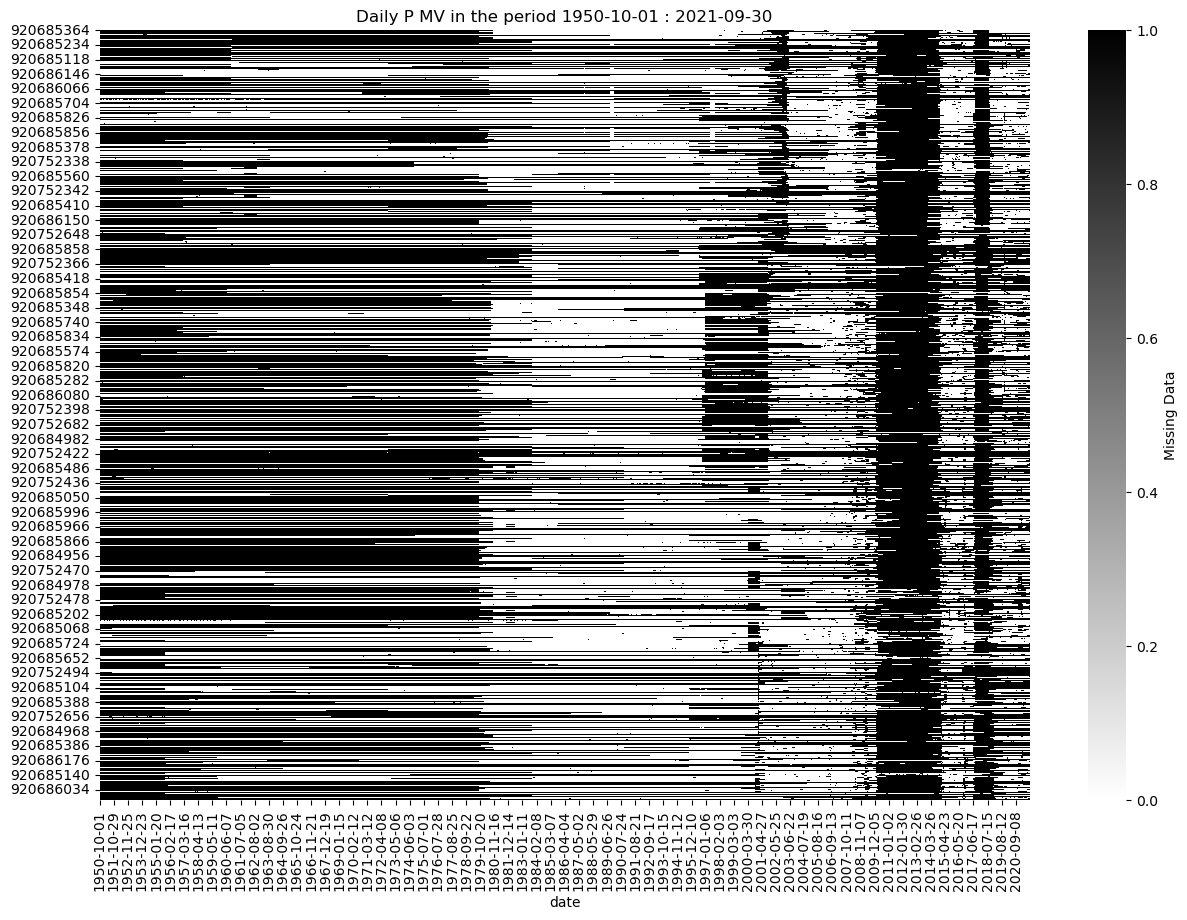

100%|██████████| 791/791 [00:00<00:00, 1227.79it/s]


In [46]:
dir_name = 'DAILY_RAINFALL'
fname = 'Daily P'

df_MV_PDaily = percMV (df_Pdaily, dict_meteo_codigo, dict_meteo_nome, wdir, dir_name, fname)

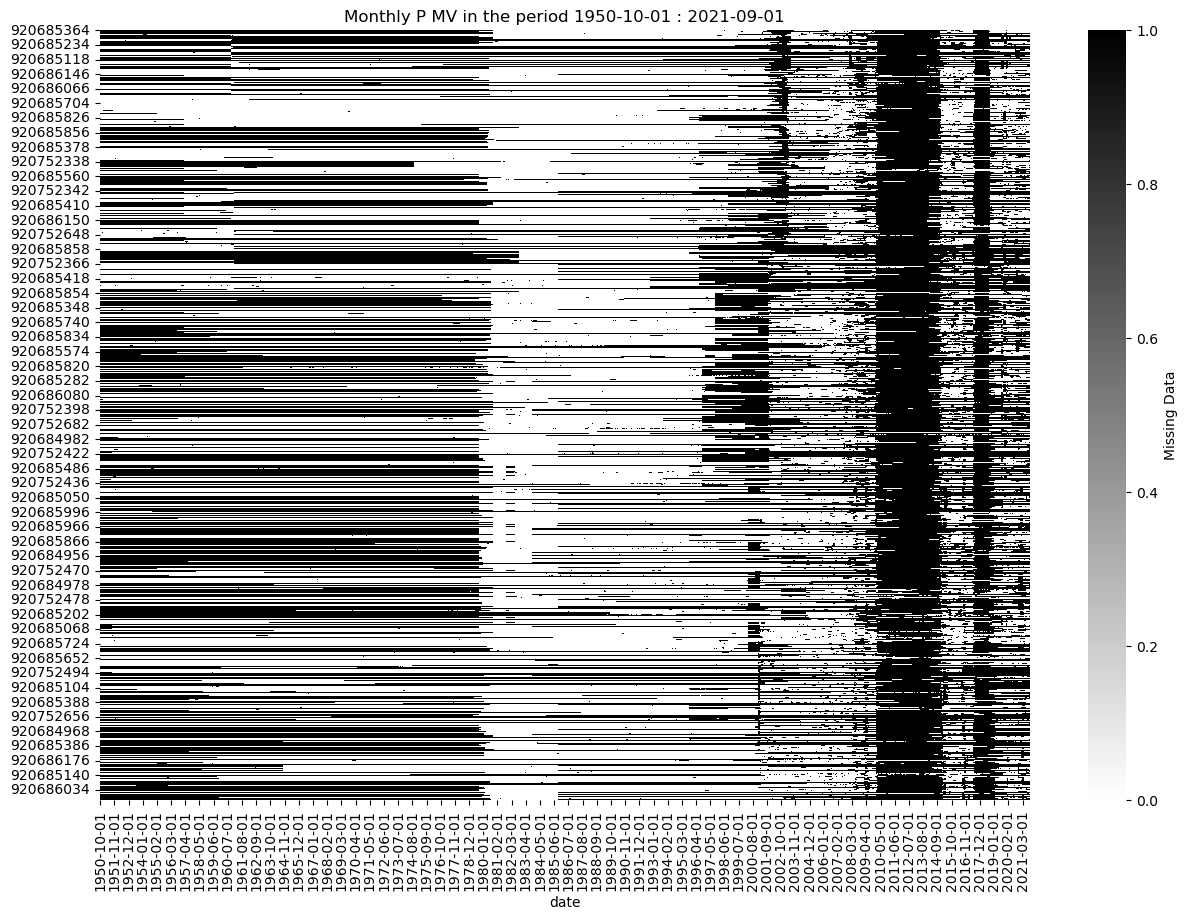

100%|██████████| 791/791 [00:00<00:00, 1387.35it/s]


In [47]:
dir_name = 'MONTHLY_RAINFALL'
fname = 'Monthly P'

df_MV_PMonthly = percMV (df_Pmonthly, dict_meteo_codigo, dict_meteo_nome, wdir, dir_name, fname)

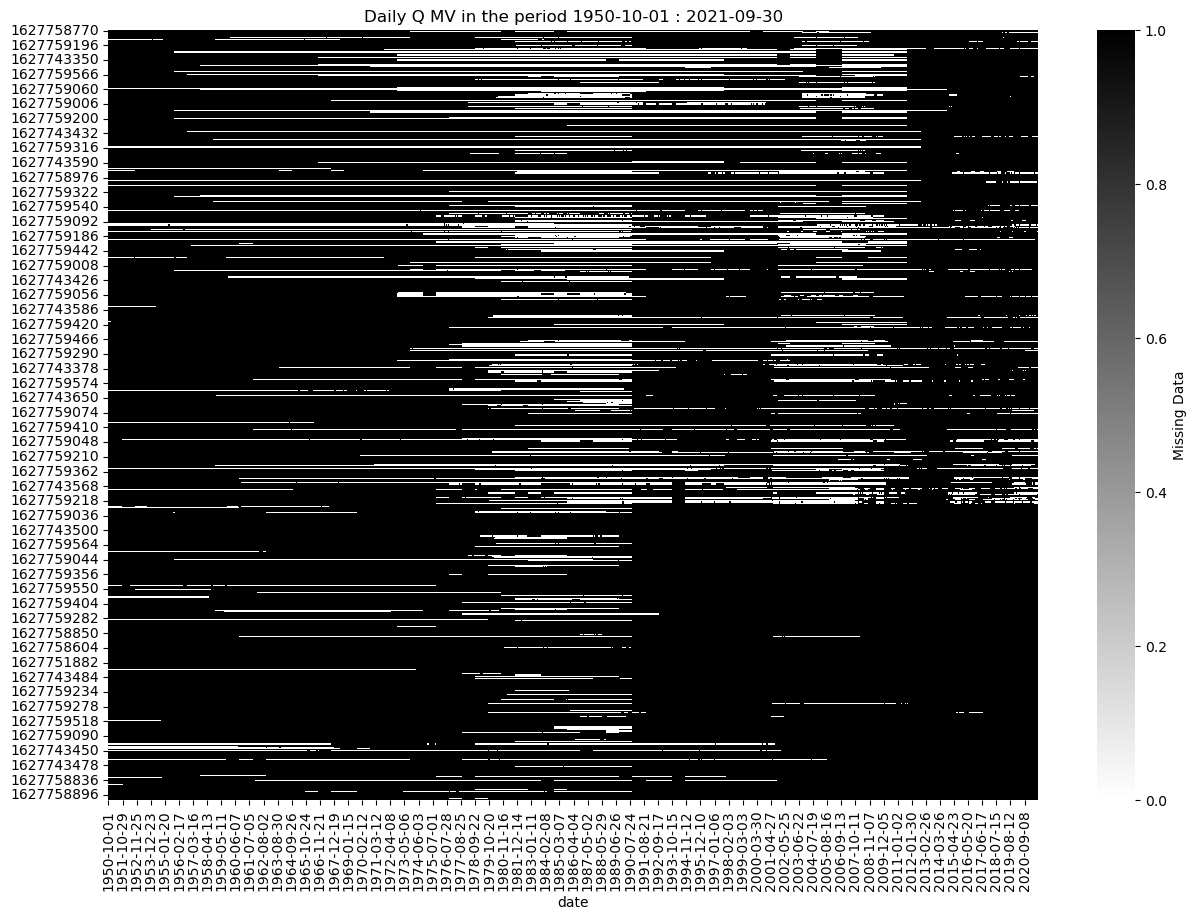

100%|██████████| 681/681 [00:00<00:00, 1397.83it/s]


In [48]:
dir_name = 'DAILY_FLOW'
fname = 'Daily Q'

df_MV_QDaily = percMV (df_Qdaily, dict_hydro_codigo, dict_hydro_nome, wdir, dir_name, fname)

In [49]:
df_MV_QMonthly

,id,Code,Name,First Date,Last Date,MV [%]
0,1627758770,NaN,NaN,NaT,NaT,100.0
1,1627758638,NaN,NaN,1973-10-01,2005-09-01,11.7
2,1627758640,NaN,NaN,2003-10-01,2021-09-01,62.5
3,1627759418,NaN,NaN,NaT,NaT,100.0
4,1627743706,NaN,NaN,NaT,NaT,100.0
...,...,...,...,...,...,...
676,1627758896,NaN,NaN,NaT,NaT,100.0
677,1627752088,NaN,NaN,NaT,NaT,100.0
678,1627743442,NaN,NaN,NaT,NaT,100.0
679,1627751884,NaN,NaN,1976-10-01,1979-09-01,33.3


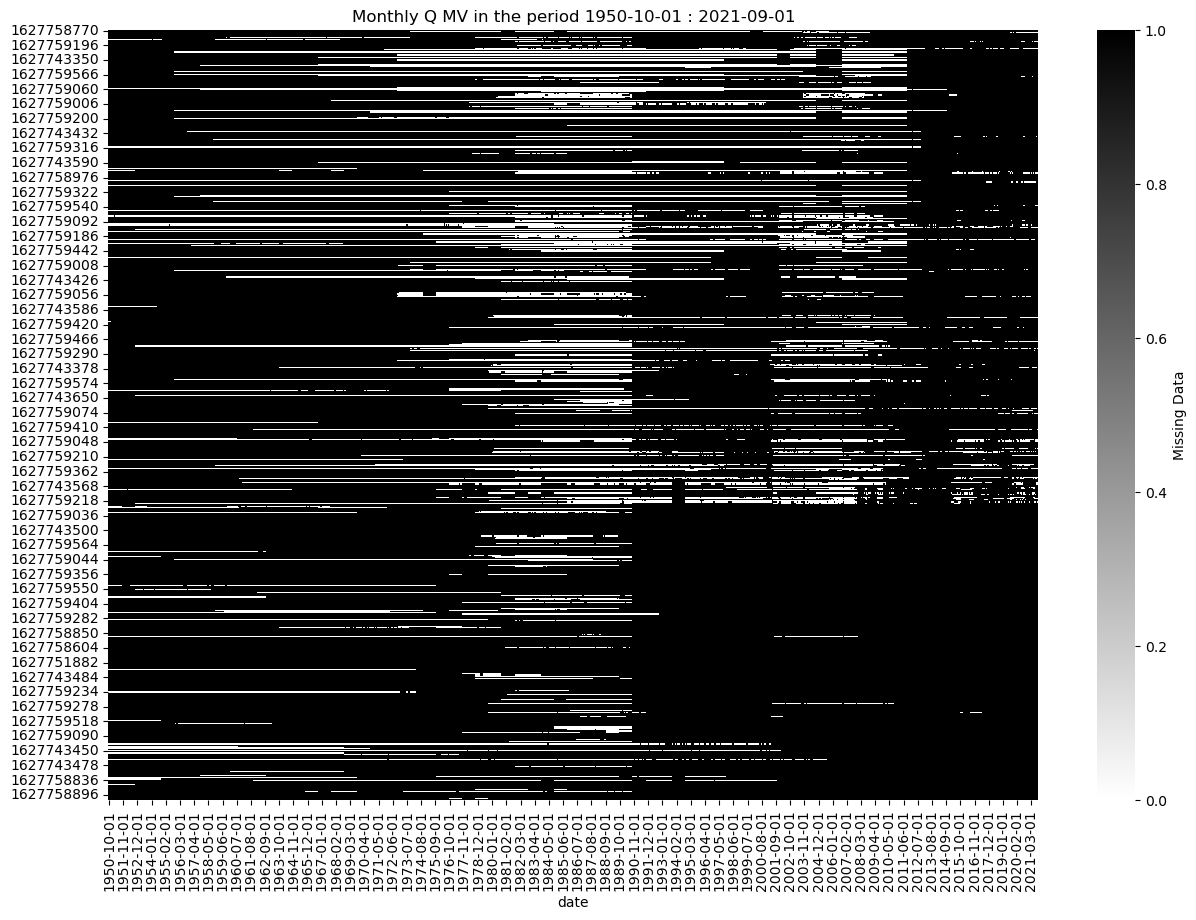

100%|██████████| 681/681 [00:00<00:00, 1562.48it/s]


In [50]:
dir_name = 'MONTHLY_FLOW'
fname = 'Monthly Q'

df_MV_QMonthly = percMV (df_Qmonthly, dict_hydro_codigo, dict_hydro_nome, wdir, dir_name, fname)